# Training code:

This notebook uses code from: https://www.pyimagesearch.com/2020/03/16/detecting-covid-19-in-x-ray-images-with-keras-tensorflow-and-deep-learning/

You can your register and get it, both code and images. Is a really good blog, you really should check it out. I will assume that's the code you are gonna use here.

**WARNING**: The code uses native tensorflow libraries, and sadly ELI5 requires native keras code (for some reason). Since both are basically the same api, the only thing you need to do is change in the library load the tensorflow imports like:

```
from tensorflow.keras.preprocessing.image import ImageDataGenerator
```

to 

```
from keras.preprocessing.image import ImageDataGenerator
```

(all of them)

And that's it!.

In [1]:
# put the code in here

In [0]:
!pip install shap eli5

     |████████████████████████████████| 276kB 2.8MB/s 
     |████████████████████████████████| 112kB 12.8MB/s 
  Created wheel for shap: filename=shap-0.35.0-cp36-cp36m-linux_x86_64.whl size=394127 sha256=d0ce6fcf13d947343bac6b3c25d7fbf1275dde2510a934b90da48745aebaa9be
  Stored in directory: /root/.cache/pip/wheels/e7/f7/0f/b57055080cf8894906b3bd3616d2fc2bfd0b12d5161bcb24ac
Successfully built shap


In [0]:
import shap
import eli5

The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.


# ELI5

Using GRAD-CAM to inspect which parts of the CNN layers have the biggest impact in the result.

Something's buggy when inspecting he whole model, so I check the last pooling block

I'm assuming the following variables:

* model : the trained keras model
* testX : numpy array with the test images (...in numpy format)
* trainX : numpy array with the train images (...in numpy format)

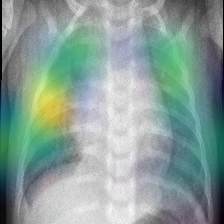

In [0]:
preds = model.predict(np.expand_dims(testX[0], axis=0))
eli5.show_prediction(model, np.expand_dims(testX[0], axis=0), layer="block5_pool")

In [0]:
for elem in model.layers:
  print(elem.name)

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool
average_pooling2d_1
flatten
dense_1
dropout_1
dense_2


In [0]:
# snippet shamelessly taken from: https://towardsdatascience.com/knowing-what-and-why-explaining-image-classifier-predictions-680a15043bad

import math
def plot_eli5_top_explanations(model, image,class_names,top_preds_count=2,fig_name=None):
    
    image_columns = 2
    image_rows = math.ceil(top_preds_count / image_columns)
    
    preds = model.predict(image)
    top_preds_indexes = np.flip(np.argsort(preds))[0,:top_preds_count]
    top_preds_values = preds.take(top_preds_indexes)
    top_preds_names = np.vectorize(lambda x: class_names[x])(top_preds_indexes)
    
    plt.style.use('dark_background')
    fig, axes = plt.subplots(image_rows, image_columns, figsize=(image_columns * 5, image_rows * 5))
    [ax.set_axis_off() for ax in axes.flat]
    
    for i, (index, value, name, ax) in \
        enumerate(zip(top_preds_indexes, top_preds_values, top_preds_names, axes.flat)):
            
        class_grad_cam = eli5.show_prediction(model, image, layer="block5_pool",targets=[int(index)])
        subplot_title = "{}. class: {} pred: {:.3f}".format(i + 1, name, value)
        ax.imshow(class_grad_cam)
        ax.set_title(subplot_title, pad=20)
    
    if fig_name:
        plt.savefig(fig_name)
    plt.show()

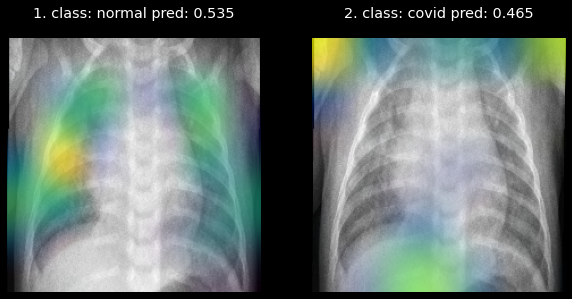

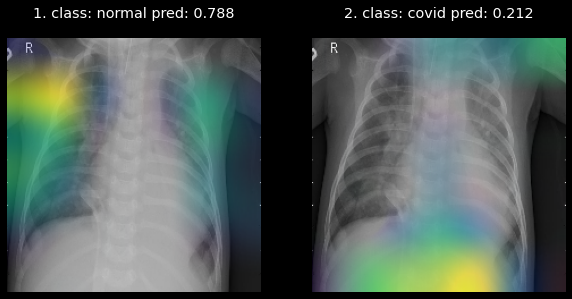

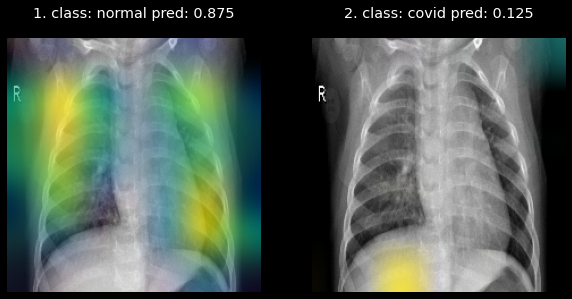

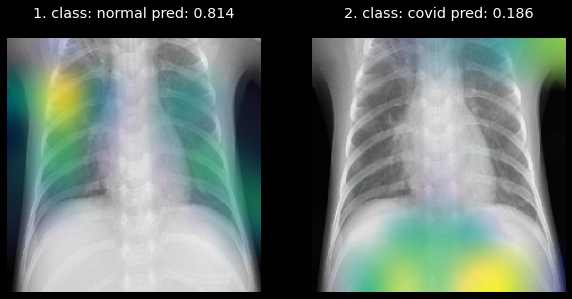

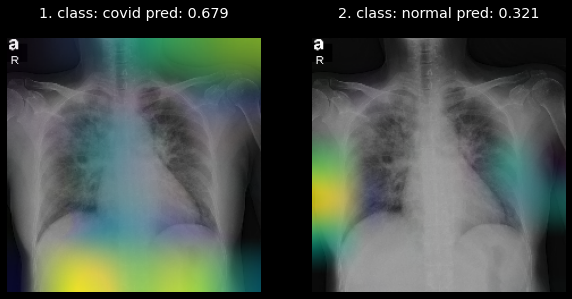

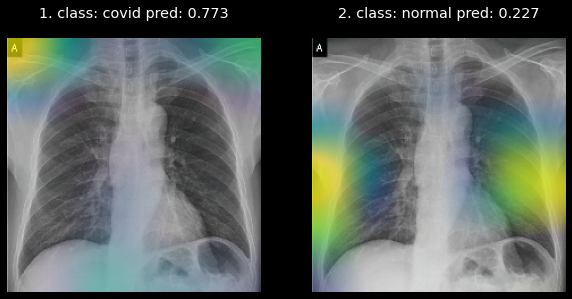

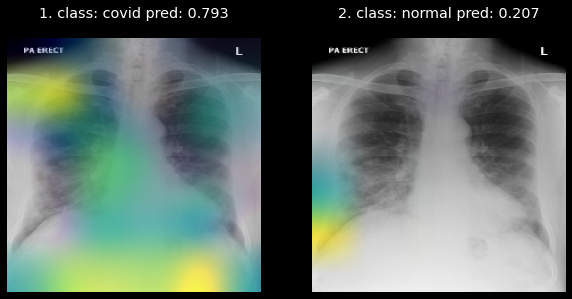

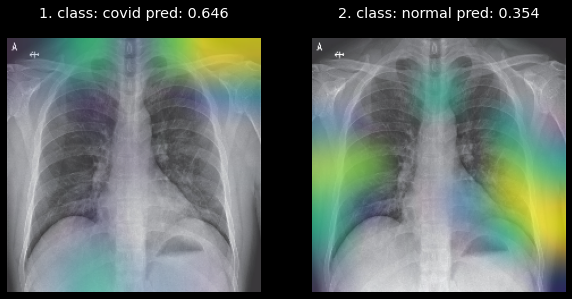

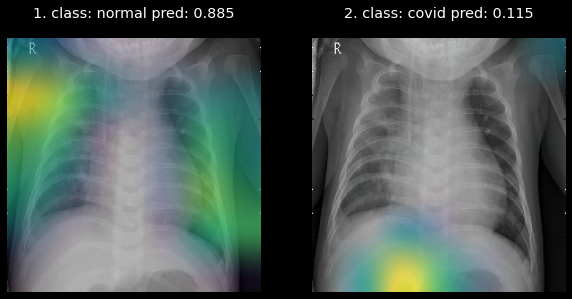

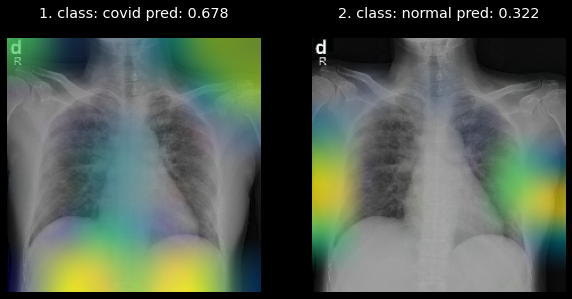

In [0]:
for i in range(10):
  plot_eli5_top_explanations(model, np.expand_dims(testX[i], axis=0), {0:"covid",1:"normal"})

# SHAP 

Beware:The Shap method extract the shaply scores, which is computationally heavy, this part is gonna be slow

In [0]:
e = shap.DeepExplainer(model, trainX)
shap_values = e.shap_values(testX)

In [0]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (50,30)

## Now shap doesn't like to play nice with some plots, so I will rewrite the image_plot() function so it returns the figure.

In [0]:
# Shap doesn't like to show the images the size I want. 

# Fine. I'll do it myself

#shap.image_plot(shap_values, testX, show=False)

In [0]:
import matplotlib.pyplot as pl
import colors

In [0]:
def image_plot(shap_values, pixel_values, labels=None, width=20, aspect=0.2, hspace=0.2, labelpad=None, show=True):
    """ Plots SHAP values for image inputs.
    Parameters
    ----------
    shap_values : [numpy.array]
        List of arrays of SHAP values. Each array has the shap (# samples x width x height x channels), and the
        length of the list is equal to the number of model outputs that are being explained.
    pixel_values : numpy.array
        Matrix of pixel values (# samples x width x height x channels) for each image. It should be the same
        shape as each array in the shap_values list of arrays.
    labels : list
        List of names for each of the model outputs that are being explained. This list should be the same length
        as the shap_values list.
    width : float
        The width of the produced matplotlib plot.
    labelpad : float
        How much padding to use around the model output labels.
    show : bool
        Whether matplotlib.pyplot.show() is called before returning. Setting this to False allows the plot
        to be customized further after it has been created.
    """

    multi_output = True
    if type(shap_values) != list:
        multi_output = False
        shap_values = [shap_values]

    # make sure labels
    if labels is not None:
        assert labels.shape[0] == shap_values[0].shape[0], "Labels must have same row count as shap_values arrays!"
        if multi_output:
            assert labels.shape[1] == len(shap_values), "Labels must have a column for each output in shap_values!"
        else:
            assert len(labels.shape) == 1, "Labels must be a vector for single output shap_values."

    label_kwargs = {} if labelpad is None else {'pad': labelpad}

    # plot our explanations
    x = pixel_values
    fig_size = np.array([3 * (len(shap_values) + 1), 2.5 * (x.shape[0] + 1)])
    if fig_size[0] > width:
        fig_size *= width / fig_size[0]
    fig, axes = pl.subplots(nrows=x.shape[0], ncols=len(shap_values) + 1, figsize=fig_size)
    if len(axes.shape) == 1:
        axes = axes.reshape(1,axes.size)
    for row in range(x.shape[0]):
        x_curr = x[row].copy()

        # make sure
        if len(x_curr.shape) == 3 and x_curr.shape[2] == 1:
            x_curr = x_curr.reshape(x_curr.shape[:2])
        if x_curr.max() > 1:
            x_curr /= 255.

        # get a grayscale version of the image
        if len(x_curr.shape) == 3 and x_curr.shape[2] == 3:
            x_curr_gray = (0.2989 * x_curr[:,:,0] + 0.5870 * x_curr[:,:,1] + 0.1140 * x_curr[:,:,2]) # rgb to gray
        else:
            x_curr_gray = x_curr

        axes[row,0].imshow(x_curr, cmap=pl.get_cmap('gray'))
        axes[row,0].axis('off')
        if len(shap_values[0][row].shape) == 2:
            abs_vals = np.stack([np.abs(shap_values[i]) for i in range(len(shap_values))], 0).flatten()
        else:
            abs_vals = np.stack([np.abs(shap_values[i].sum(-1)) for i in range(len(shap_values))], 0).flatten()
        max_val = np.nanpercentile(abs_vals, 99.9)
        for i in range(len(shap_values)):
            if labels is not None:
                axes[row,i+1].set_title(labels[row,i], **label_kwargs)
            sv = shap_values[i][row] if len(shap_values[i][row].shape) == 2 else shap_values[i][row].sum(-1)
            axes[row,i+1].imshow(x_curr_gray, cmap=pl.get_cmap('gray'), alpha=0.15, extent=(-1, sv.shape[1], sv.shape[0], -1))
            im = axes[row,i+1].imshow(sv, cmap=colors.red_transparent_blue, vmin=-max_val, vmax=max_val)
            axes[row,i+1].axis('off')
    if hspace == 'auto':
        fig.tight_layout()
    else:
        fig.subplots_adjust(hspace=hspace)
    cb = fig.colorbar(im, ax=np.ravel(axes).tolist(), label="SHAP value", orientation="horizontal", aspect=fig_size[0]/aspect)
    cb.outline.set_visible(False)
    # oh my a simple change
    return fig
    if show:
        pl.show()

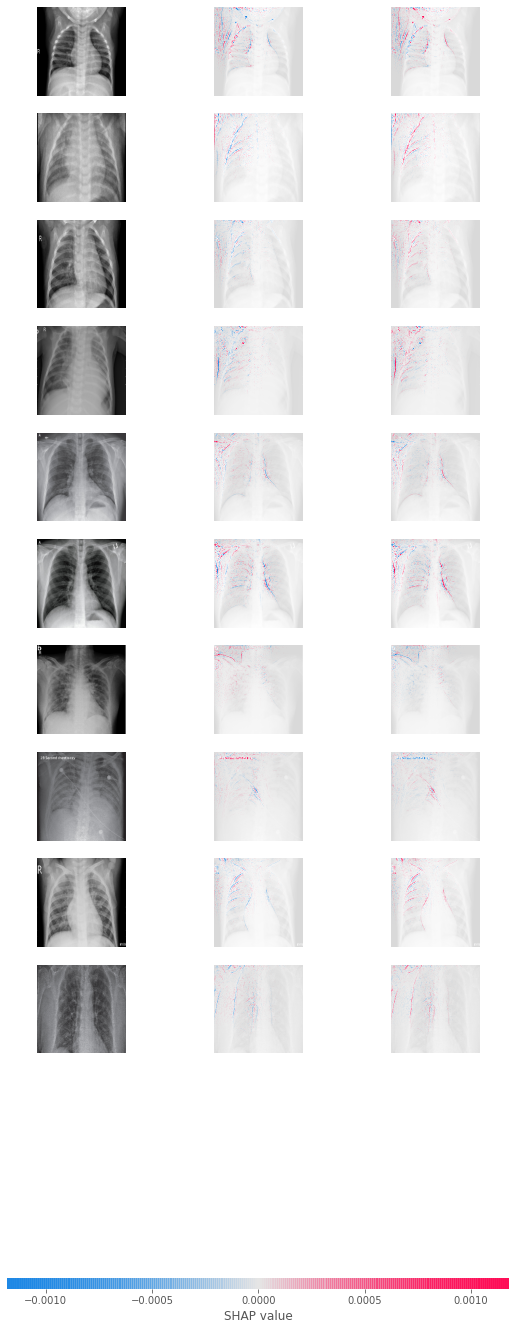

In [0]:
fig = image_plot(shap_values, testX, show=False)

In [0]:
fig.savefig('shap.png', dpi=512)